<br><font color='red' size=8><u>Netflix Movie</u></font><br><br><font color='red' size=8><u>Recommendation Engine</u></font>

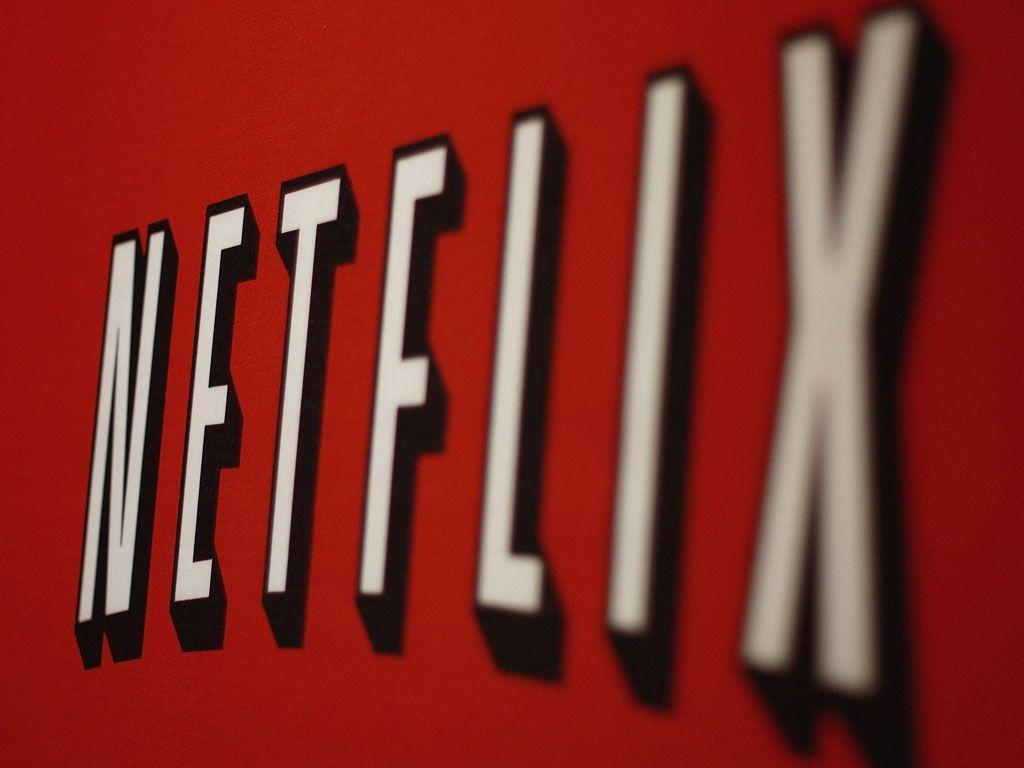

<b><font color='red'>Netflix</font> held the <font color='red'>Netflix Prize open competition</font> for the <font color='red'>best algorithm</font> to <font color='red'>predict user ratings</font> for <font color='red'>films</font>. The <font color='red'>grand prize</font> was <font color='red'>$1,000,000</font>. This is the <font color='red'>dataset</font> that was used in that competition and we're going to use it to built an effective <font color='red'>recommendation engine</font>.</b>

<b>There's a <font color='red'>movie_titles.csv</font> file containing the <font color='red'>details</font> of the <font color='red'>movie</font> and there are 4 other <font color='red'>combined_data_(1,2,3,4).txt</font> files containing the <font color='red'>user ratings</font>.</b>

# <font color='red'>Loading the dependencies and the data</font>

In [1]:
# importing basic dependencies
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
# loading the movie_titles.csv
movies=pd.read_csv('movie_titles.csv', names=['id','year','title'])

# peek into the dataframe
movies.head()

,id,year,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      17770 non-null  int64  
 1   year    17763 non-null  float64
 2   title   17770 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 416.6+ KB


<b>In the following piece of code we're <font color='red'>combining</font> all the <font color='red'>four text files</font> containing the <font color='red'>user ratings</font> into one massive <font color='red'>rating.csv file</font>.</b>

In [4]:
# creating a new file if it doesn't exist already
if not os.path.isfile('rating.csv'):
    
    # opening the newly created file on the 'write' mode
    rating=open('rating.csv', mode='w')
    
    separated_data=['combined_data_1.txt','combined_data_2.txt',
                    'combined_data_3.txt','combined_data_4.txt']
    
    # iterating through the separate files containing the user ratings
    for file in separated_data:
        with open(file) as f:
            # processing each line of the currently open file
            for line in f: 
                line=line.strip()
                if line[-1]==':':
                    movie_id=line[:-1]
                else:
                    combining_rows=[x for x in line.split(',')]
                    combining_rows=[movie_id]+combining_rows
                    rating.write(','.join(combining_rows))
                    rating.write('\n')
        f.close()
    rating.close()

In [5]:
# loading the above new csv file into a dataframe
rating=pd.read_csv('rating.csv', sep=',', 
                   names=['Movie_Id', 'Customer_Id','Rating','Date'])

In [6]:
# peek into the dataframe
rating.head()

,Movie_Id,Customer_Id,Rating,Date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [7]:
# merging the movies dataframe with rating dataframe
df=pd.merge(movies, rating, left_on='id', right_on='Movie_Id', how='inner')

In [8]:
# peek into the dataframe
df.head()

,id,year,title,Movie_Id,Customer_Id,Rating,Date
0,1,2003.0,Dinosaur Planet,1,1488844,3,2005-09-06
1,1,2003.0,Dinosaur Planet,1,822109,5,2005-05-13
2,1,2003.0,Dinosaur Planet,1,885013,4,2005-10-19
3,1,2003.0,Dinosaur Planet,1,30878,4,2005-12-26
4,1,2003.0,Dinosaur Planet,1,823519,3,2004-05-03


<b>Clearly we can drop <font color='red'>id</font> as it is merely as copy of <font color='red'>Movie_Id</font> and the <font color='red'>title</font>, <font color='red'>year</font> and <font color='red'>Date</font> are also not relevant in the context of building a <font color='red'>recommendation system</font>.</b> 

<b>We're going to work with the following three variables only <font color='red'>Movie_Id</font>, <font color='red'>Customer_Id</font> and <font color='red'>Rating</font>.</b>

In [9]:
# dropping the unnecessary variables
df=df[['Movie_Id', 'Customer_Id', 'Rating']]

# <font color='red'>Exploratory Data Analysis</font>

In [10]:
# checking the metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 0 to 100480506
Data columns (total 3 columns):
 #   Column       Dtype
---  ------       -----
 0   Movie_Id     int64
 1   Customer_Id  int64
 2   Rating       int64
dtypes: int64(3)
memory usage: 3.0 GB


In [11]:
print(f'There are {df.Movie_Id.unique().shape[0]} unique movies in the dataframe')

There are 17770 unique movies in the dataframe


In [12]:
print(f'There are {df.Customer_Id.unique().shape[0]} customers in the dataframe')

There are 480189 customers in the dataframe


In [13]:
print(f"The minimum Customer_Id and the maximum Customer_Id in the df are {df.Customer_Id.min()} and {df.Customer_Id.max()} respectively and we \nknow that there are only {df.Customer_Id.unique().shape[0]} unique customers in the df which will lead to confusion. Hence we're going to map them as continuous integers")

The minimum Customer_Id and the maximum Customer_Id in the df are 6 and 2649429 respectively and we 
know that there are only 480189 unique customers in the df which will lead to confusion. Hence we're going to map them as continuous integers


In [14]:
# creating a dict map to map old Customer_Id to new and continuous Customer_Id
mapping={old:new for old,new in 
         list(zip(sorted(df.Customer_Id.unique()),
                  range(df.Customer_Id.unique().shape[0])))}

In [15]:
# applying the above mapping
df['Customer_Id']=df['Customer_Id'].map(mapping)

In [16]:
# checking if the new Customer_Id is continuous
print(df.Customer_Id.unique().shape[0])
print(df.Customer_Id.min())
print(df.Customer_Id.max())

480189
0
480188


<b>Checking the <font color='red'>distribution</font> of <font color='red'>popularity</font> of the <font color='red'>movies</font></b>

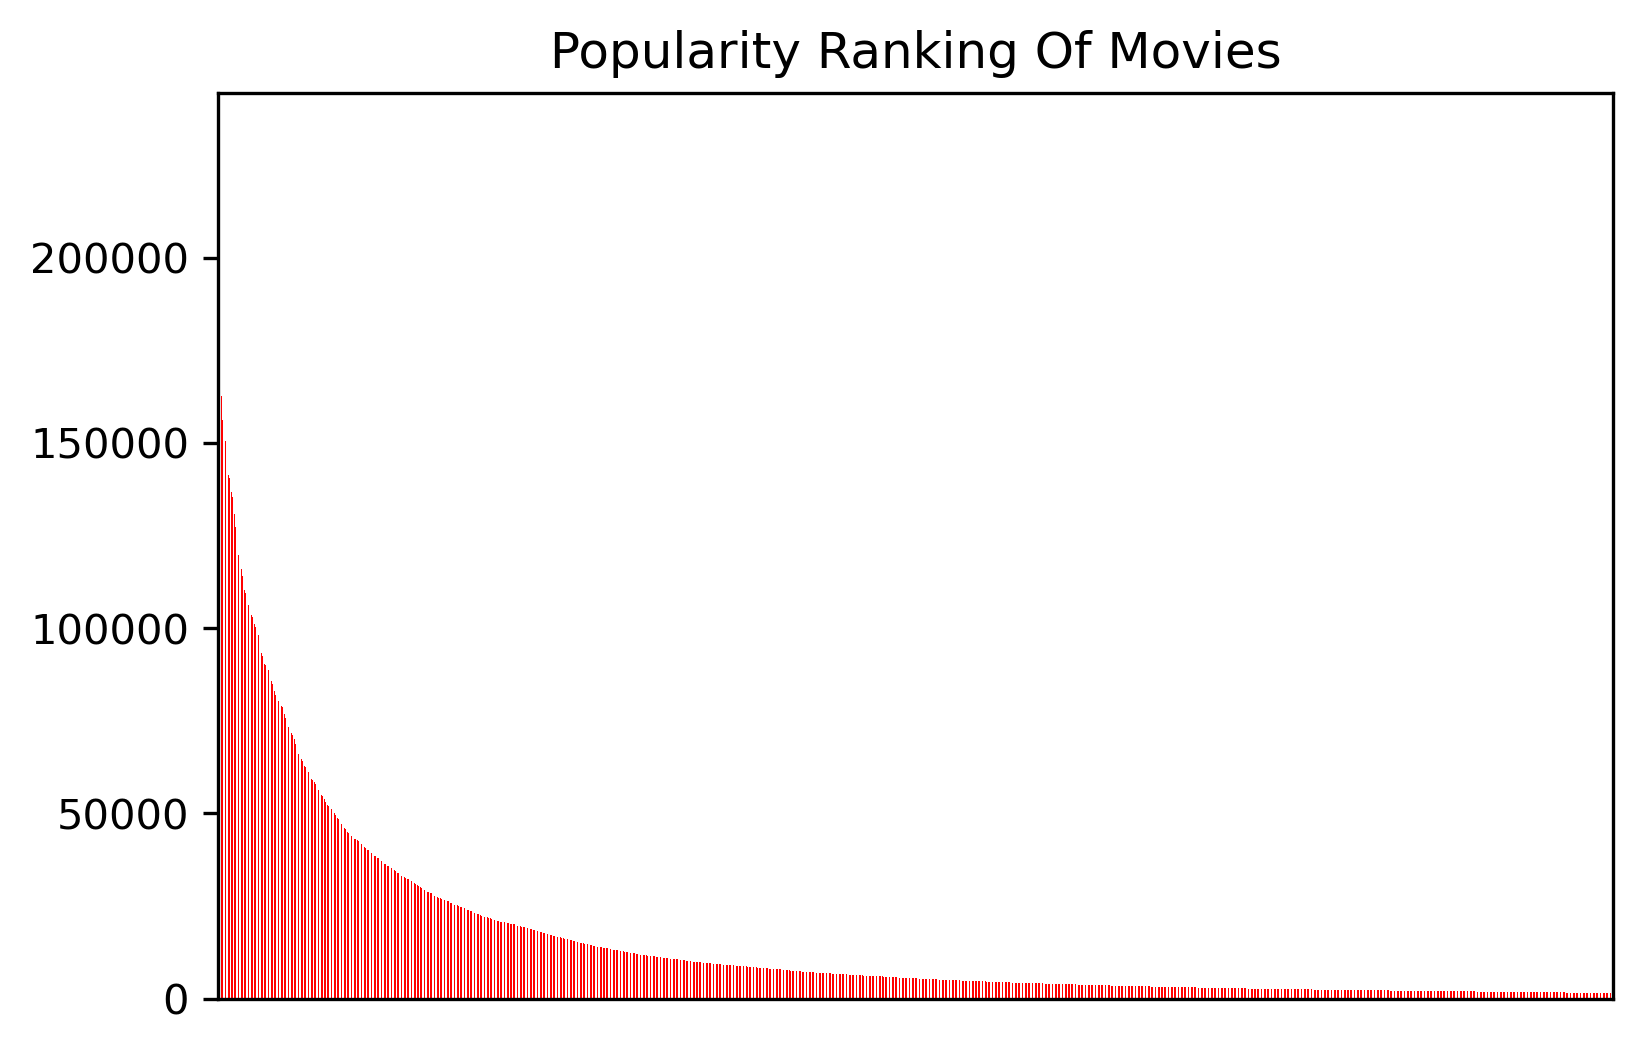

In [17]:
plt.figure(dpi=300)
plt.title('Popularity Ranking Of Movies')
df.Movie_Id.value_counts()[:6000].plot(kind='bar', color='red')
plt.xticks(ticks=[]);

<b>The above plot shows the <font color='red'>long tail distribution</font> of the movies. The first <font color='red'>few 100 movies</font> or so have ratings <font color='red'>steeply dropping</font> from <font color='red'>230000</font> to <font color='red'>50000</font> and the rest of the movies have very low number of ratings. <font color='grey'>(Note that we've considered only the 6000 most popular movies).</font></b>

<b>Checking the <font color='red'>distribution</font> of <font color='red'>ratings</font> of the <font color='red'>movies</font></b>

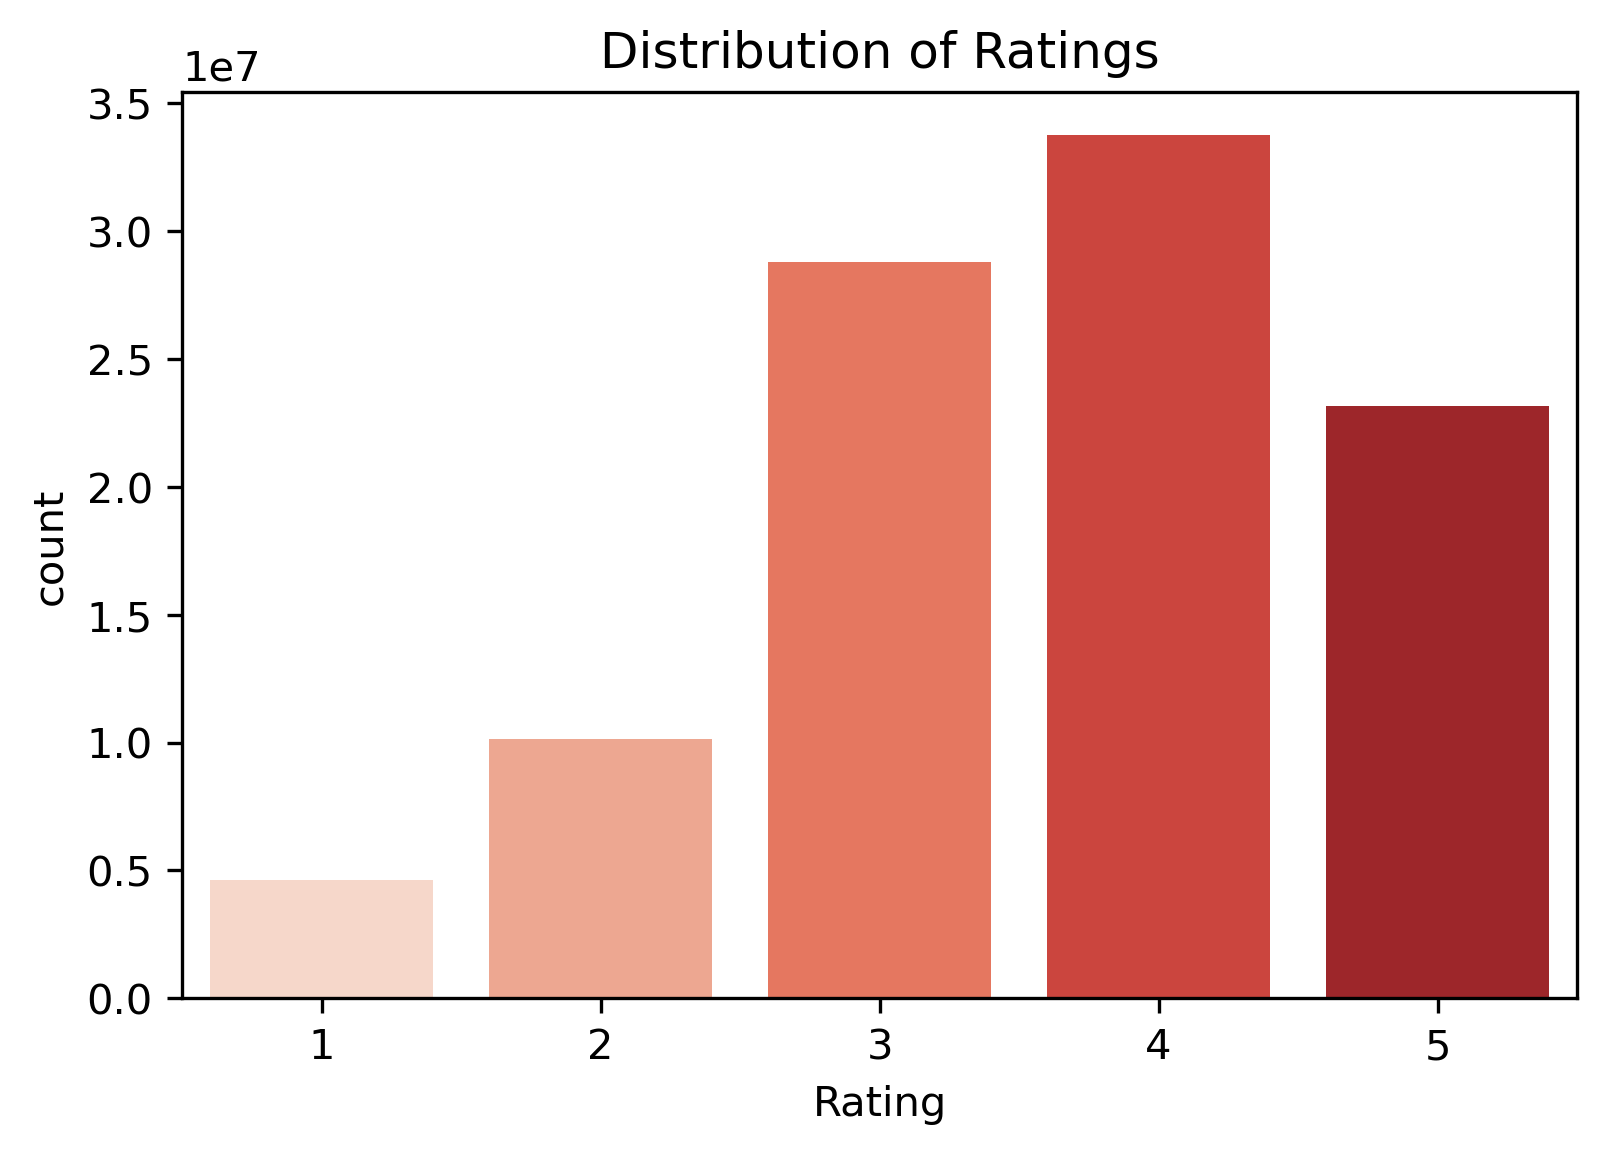

In [18]:
plt.figure(dpi=300)
plt.title('Distribution of Ratings')
sns.countplot(df.Rating, palette='Reds');

<b>As we can clearly see that <font color='red'>4 stars</font> and <font color='red'>3 stars</font> are the <font color='red'>most</font> and the <font color='red'>second most frequent ratings</font> given by users.</b>

In [19]:
# there are no NaNs in any of the columns
df.isna().sum()

Movie_Id       0
Customer_Id    0
Rating         0
dtype: int64

In [20]:
# there are no duplicated ratings
df.duplicated(['Movie_Id','Customer_Id']).sum()

0

<b>List of <font color='red'>top 20 best</font> movies as per the <font color='red'>average user rating</font>.</b>

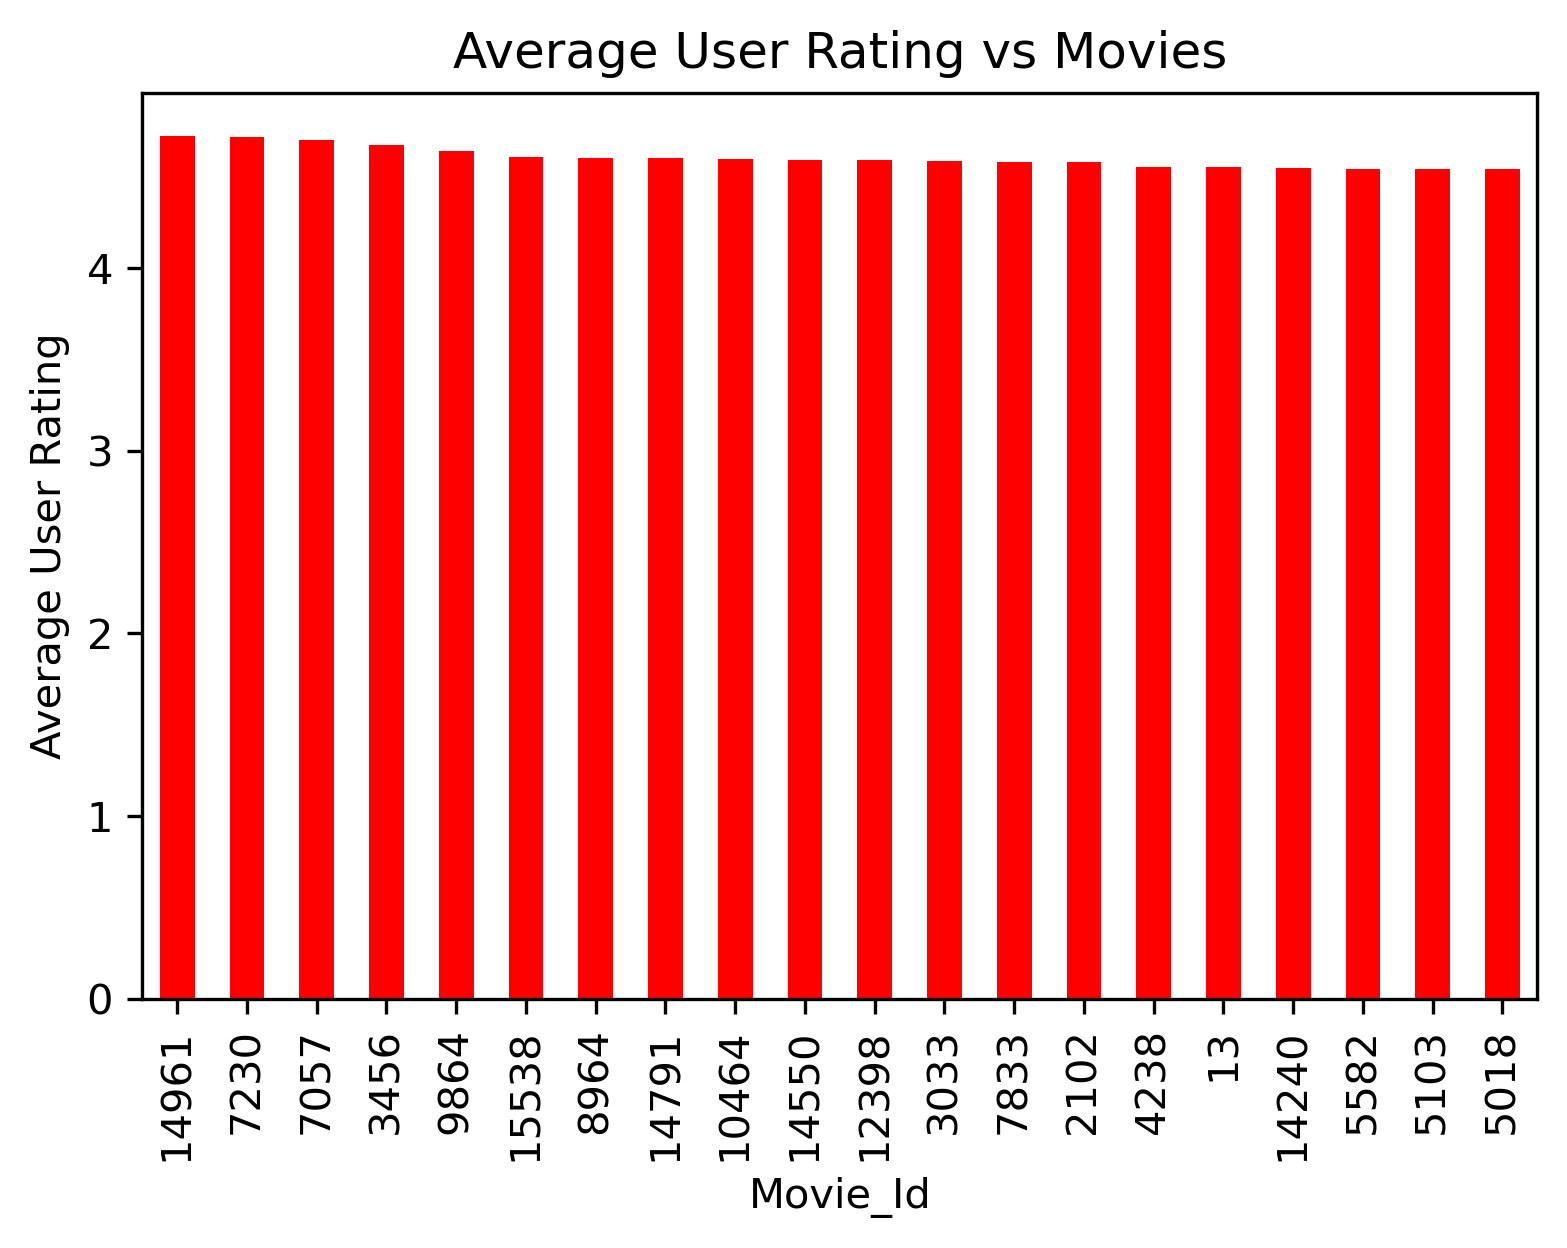

In [21]:
# average user rating of top 20 movies
plt.figure(dpi=300)
plt.title('Average User Rating vs Movies')
plt.ylabel('Average User Rating')
(df.groupby(by='Movie_Id')['Rating']
 .mean().sort_values(ascending=False)[:20]).plot(kind='bar', color='red');

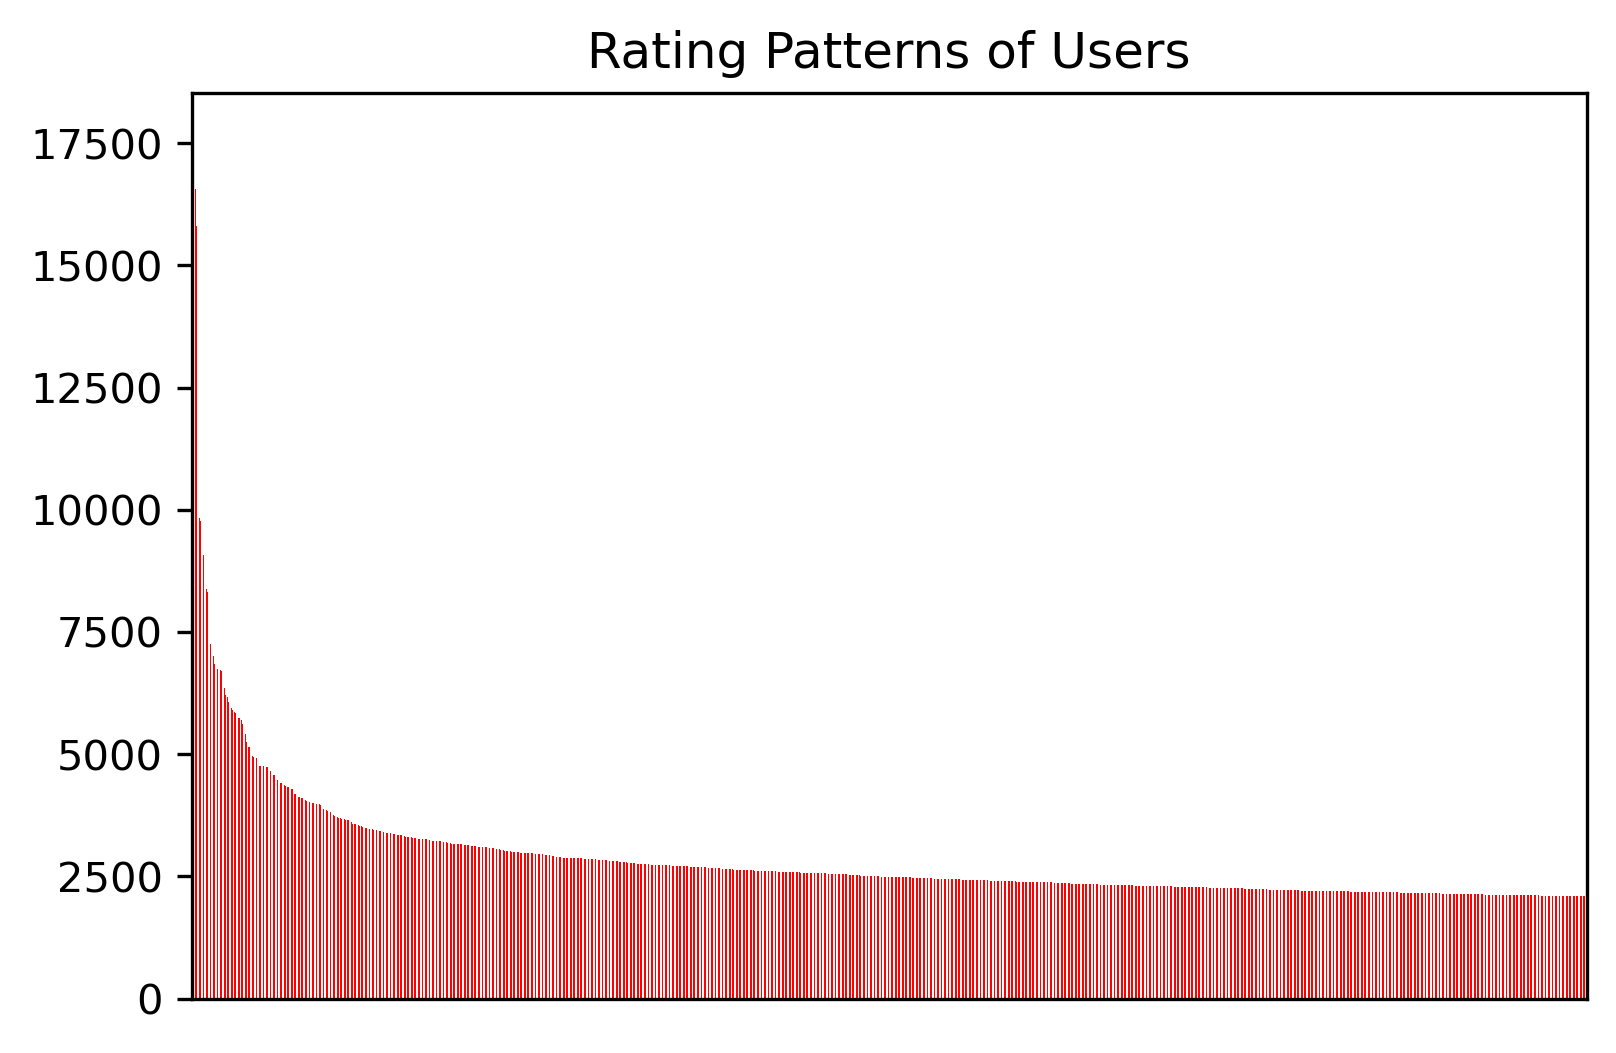

In [22]:
plt.figure(dpi=300)
plt.title('Rating Patterns of Users')
df.Customer_Id.value_counts()[:1000].plot(kind='bar', color='red')
plt.xticks(ticks=[]);

<b>The above plot displays the <font color='red'>rating patterns</font> of the <font color='red'>top 1000 frequent users</font> and their rating behavior ranges from rating almost all movies to rating only handful of movies</b>

In [23]:
# statistical description of ratings
df.Rating.describe()

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

# <font color='red'>Utility Matrix</font>

<b>Here we're going to produce the <font color='red'>utility matrix</font> by <font color='red'>pivot</font>ing the <font color='red'>dataframe df</font> with <font color='red'>Movie_Id</font> as <font color='red'>rows</font>, <font color='red'>Customer_Id</font> as <font color='red'>columns</font> and the <font color='red'>Rating</font> as the cell <font color='red'>values</font>. Also we're going to use <font color='red'>item-item cosine similarity based collaborative filtering</font> technique to build our <font color='red'>recommendation system</font>.</b>
    
<b>Let's <font color='red'>centre</font> the <font color='red'>rating vectors</font> of every <font color='red'>movie</font> by <font color='red'>subtracting</font> it by <font color='red'>average rating</font> of the movie. We're doing this in order to make better sense of the <font color='red'>cosine similarity</font>.</b>

In [24]:
# finding the average rating for each movie
mean_rating=df.groupby(by='Movie_Id')[['Rating']].mean()
mean_rating.head()

,Rating
Movie_Id,
1,3.749543
2,3.558621
3,3.641153
4,2.739437
5,3.919298


In [25]:
# merging the above df with the original df
tmp=pd.merge(df, mean_rating, left_on='Movie_Id', 
             right_index=True, how='inner')
tmp.head()

,Movie_Id,Customer_Id,Rating_x,Rating_y
0,1,270045,3,3.749543
1,1,149546,5,3.749543
2,1,160878,4,3.749543
3,1,5466,4,3.749543
4,1,149791,3,3.749543


In [26]:
# creating a df containing the movie-wise centred ratings
df=tmp[['Movie_Id','Customer_Id']]
df['Rating']=tmp['Rating_x']-tmp['Rating_y']
df.head()

,Movie_Id,Customer_Id,Rating
0,1,270045,-0.749543
1,1,149546,1.250457
2,1,160878,0.250457
3,1,5466,0.250457
4,1,149791,-0.749543


<b>Since <font color='red'>utility matrix</font> is going to be a massive, we're going to use <font color='red'>csr_matrix</font> to represent it.</b>

In [27]:
rows=df.Movie_Id.values
cols=df.Customer_Id.values
data=df.Rating.values
utility=sp.sparse.csr_matrix((data, (rows, cols)), 
shape=(1+df.Movie_Id.unique().shape[0],1+df.Customer_Id.unique().shape[0]))
utility

<17771x480190 sparse matrix of type '<class 'numpy.float64'>'
	with 100480507 stored elements in Compressed Sparse Row format>

In [28]:
# unsupervised learning algo for recommendation system
from sklearn.neighbors import NearestNeighbors

In [29]:
# capturing the pair of movie index and user index who actually rated the movie
mov_idx,user_idx=utility.nonzero()

# <font color='red'>Recommender System Based On Collaborative Filtering Item-Item Cosine Similarity</font>

In [30]:
def recommendations(user_id):
    # list of top 5 movies rated by the given user
    user_top_movies=utility[:,user_id].toarray().reshape(-1,)
    
    # finding the argmax for top 5 ratings
    user_top_movies=user_top_movies.argsort()[-5:][::-1]
    
    print(f'The list of top 5 rated movies by the Customer_Id {user_id} are')
    for film in movies.iloc[user_top_movies]['title'].values:
          print(film)
  
    # rating vectors of all the movies rated by this user
    # in otherwords utility submatrix
    sub_utility=utility[mov_idx[user_idx==user_id]]
    
    # instantiating KNN model with default 5 neigbors
    knn=NearestNeighbors(metric='cosine', n_jobs=-1, algorithm='brute')
    
    # training the above algorithm on the utility submatrix 
    knn.fit(sub_utility)
    
    # collecting list of movies not watched by this user
    unwatched
    =list(set(range(1,17771)).difference(set(mov_idx[user_idx==user_id])))
    
    unwatched_rating=[-10]*17771
    # for every unwatched film by this user
    for newfilm in unwatched:
        
        # we're finding the rating vector of the movie
        rate_vector=utility[newfilm].toarray()
        
        # extracting the cosine distances and movie_id
        distance,movieid=knn.kneighbors(rate_vector, 5, return_distance=True)
        
        # reshape the distance and the ids
        distance,movieid=distance.reshape(-1,),movieid.reshape(-1,)
        
        # converting cosine distance to cosine similarity
        similarity=1-distance
        
        # ratings of the aforementioned 5 most similar movies by this user
        rates=utility[:,user_id][movieid].toarray().reshape(-1,)
        
        # finding the weighted mean of the 5 highly rated movies
        predicted_rating=np.dot(similarity,rates)/np.abs(similarity).sum()
        
        # assigning the predicted_rating at the respective index 
        # corresponding to the movie index
        unwatched_rating[newfilm]=predicted_rating
    
    # converting it to numpy array
    unwatched_rating=np.array(unwatched_rating)
    
    # finding the argmax for top 5 ratings
    top_recommends=unwatched_rating.argsort()[-5:][::-1]
    
    print(f'\nThe list of top 5 recommended movies for the Customer_Id {user_id} are')
    for recommend in movies.iloc[top_recommends]['title'].values:
          print(recommend)

# <font color='red'>Making Recommendations</font>

<b>The <font color='red'>recommender function</font> will first display <font color='red'>top 5 highly rated</font> movies by a given <font color='red'>Customer_ID</font> and then it'll display <font color='red'>top 5 recommended</font> movies for this user. <font color='red'>Do not expect</font> these <font color='red'>recommended movies</font> to be <font color='red'>similar</font> to these <font color='red'>top 5 highly rated</font> movies by the user. <font color='red'>Top 5 highly rated</font> movies are displayed only to give you a gist of this particular user's taste however this meagre list of top 5 cannot capture the his taste completely <font color='grey'>(Imagine this user has given 5 star rating for 40 movies and the top 5 highly rated movies by this user will be just the first instance of the top 5)</font>. But the <font color='red'>top 5 recommendations take into all the movies that the user has rated</font>.</b>

In [31]:
recommendations(160179)

The list of top 5 rated movies by the Customer_Id 160179 are
Proof Positive    
The Bible Collection: Joseph    
Dragon Ball: King Piccolo Saga: Part 2    
Last Flight of Noah's Ark    
Grind    

The list of top 5 recommended movies for the Customer_Id 160179 are
Bonjour Monsieur Shlomi    
Lois & Clark: The New Adventures of Superman: Season 1    
Kojak: Season 1    
It Was a Wonderful Life    
Inner Senses    


In [32]:
recommendations(82281)

The list of top 5 rated movies by the Customer_Id 82281 are
Beauty and the Beast: Special Edition    
The Velocity of Gary    
Love Me Tonight    
Head On    
Gladiator    

The list of top 5 recommended movies for the Customer_Id 82281 are
Para Para Sakura    
Disorganized Crime    
High Times' Potluck    
Worth Winning    
Earth vs. The Flying Saucers    


# <font color='red'>Recommending Similar Movies While Searching</font>

In [33]:
# nearest_neighbor object to find the similar movies
similar_movies=NearestNeighbors(metric='cosine', n_jobs=-1, algorithm='brute')

# fitting the above learning algo on the utility matrix
similar_movies.fit(utility)

def search():
    # lower casing the searched title
    movie_name=input('Enter your search phrase here: ').lower()
    
    # finding the matches in the list of movie titles
    filtered=movies[movies.title.str.lower().str.contains(movie_name)]
    
    if len(filtered)==0: 
        print("Couldn't find this movie. Please try again!")
        return
    if len(filtered)>10:
        print("Search phrase is too generic. Please try again!")
        return
    
    print(f'\nTop matches for your search phrase are:')
    for title in filtered.title.values:
        print(title)
    
    match_ids=filtered.id.values # list of search phrase matching movie ids
    similar_ids=[]
    seen=set() # to avoid repeatedly recommending same movie
    
    for ids in match_ids:
        # capturing cosine distance and similar movie id from kneighbors
        # for ids from every matching id
        dis,mov=similar_movies.kneighbors(utility[ids],
                                          n_neighbors=6,
                                          return_distance=True)
        for i in range(1,6):
            # adding the cosine distance and similar movie id as long as
            # the similar movie id is not already in the match_ids list
            if (mov[0][i] not in match_ids) and (mov[0][i] not in seen):
                seen.add(mov[0][i])
                similar_ids.append([dis[0][i],mov[0][i]])
    
    similar_ids.sort(key=lambda x:x[0]) # sorting based on the distance
    
    print(f'\nRecommended watch:')
    for dist, mov_id in similar_ids[:10]:
        # printing only the titles of the top 10 most similar movies
        print(movies.title.values[movies.id==mov_id][0])

In [34]:
search()

Enter your search phrase here: sdfhjk
Couldn't find this movie. Please try again!


In [35]:
search()

Enter your search phrase here: a
Search phrase is too generic. Please try again!


In [36]:
search()

Enter your search phrase here: the godfather

Top matches for your search phrase are:
The Godfather  Part II   
The Godfather  Part III   
The Godfather    
The Godfather Trilogy: Bonus Material    

Recommended watch:
GoodFellas: Special Edition    
One Flew Over the Cuckoo's Nest    
The Silence of the Lambs    
Apocalypse Now    
Star Wars: Episode I: The Phantom Menace    
Hannibal    
Scarface: 20th Anniversary Edition    
The Devil's Advocate    
Seven: Bonus Material    
Scarface: 20th Anniversary Edition: Bonus Material    


In [37]:
search()

Enter your search phrase here: finding nemo

Top matches for your search phrase are:
Finding Nemo (Widescreen)    
Finding Nemo (Full-screen)    

Recommended watch:
Monsters  Inc.   
Shrek (Full-screen)    
Shrek 2    
A Bug's Life    
The Incredibles    
Toy Story 2    


In [38]:
search()

Enter your search phrase here: Shaolin Soccer

Top matches for your search phrase are:
Shaolin Soccer    

Recommended watch:
Kung Fu Hustle    
The Legend of Drunken Master    
Iron Monkey    
The Blind Swordman: Zatoichi    
Once Upon a Time in China 2    


<b>You can see from the above examples that<br>
If we search for a <font color='red'>gangster movie</font>, then our model <font color='red'>recommends</font> similar <font color='red'>gangster movies</font>.<br>
If we search for a <font color='red'>animated movie</font>, then our model <font color='red'>recommends</font> similar <font color='red'>animated movies</font>.<br>
    If we search for a <font color='red'>chinese movie</font>, then our model <font color='red'>recommends</font> similar <font color='red'>chinese movies</font>.<br>    
The highlight is that, all these <font color='red'>recommendations</font> are purely based on the <font color='red'>similarity</font> between the <font color='red'>ratings</font> of the movies, not based on the <font color='red'>similarity</font> between the <font color='red'>content</font> of the movies. Because our <font color='red'>model</font> is built using <font color='red'>collaborative filtering</font> approach and not using <font color='red'>content based filtering</font> approach.</b>